In [ ]:
#Quandl/Nasdaq data

In [117]:
import quandl
quandl.ApiConfig.api_key = 'xi-S9FVvB87vbdfpnfHZ'

In [118]:
import numpy as np
import pandas as pd
#pd.core.common.is_list_like = pd.apo.types.is_list_like
import pandas_datareader.data as web
%matplotlib inline

def get_symbols(symbols, data_source, begin_date=None, end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df=web.DataReader(symbol, data_source, begin_date, end_date, api_key=quandl.ApiConfig.api_key)\
        [['AdjOpen','AdjHigh','AdjLow', 'AdjClose', 'AdjVolume']].reset_index()
        df.columns=['date','open','high','low','close','volume']
        df['symbol'] =symbol
        df=df.set_index(['date','symbol'])
        out=pd.concat([out,df],axis=0)
    return out.sort_index()

prices = get_symbols(['AAPL', 'CSCO'],data_source='quandl', begin_date='2015-01-01',\
                    end_date = '2017-01-01')

In [120]:
prices.head(20)

open        high         low       close      volume
date       symbol                                                            
2015-01-02 AAPL    105.820966  105.868466  101.982949  103.863957  53204626.0
           CSCO     25.385655   25.622564   24.948286   25.157859  22926512.0
2015-01-05 AAPL    102.875953  103.217954  100.139941  100.937944  64285491.0
           CSCO     24.893615   25.012069   24.602035   24.656706  29460603.0
2015-01-06 AAPL    101.213446  102.058949   99.398938  100.947444  65797116.0
           CSCO     24.725045   25.221642   24.638482   24.647594  47297634.0
2015-01-07 AAPL    101.840448  102.790453  101.360696  102.362951  40105934.0
           CSCO     24.729601   24.966509   24.583811   24.875391  27570801.0
2015-01-08 AAPL    103.768957  106.542969  103.265455  106.295968  59364547.0
           CSCO     25.094076   25.595228   25.030293   25.066740  40906993.0
2015-01-09 AAPL    107.036971  107.587974  104.699961  106.409968  53315099.0
           CSCO     25.212530   25.577004   25.012069   25.321872  33278574.0
2015-01-12 AAPL    106.970471  106.998971  103.360455  103.787957  49650790.0
           CSCO     25.513221   25.695459   25.349208   25.558781  38648396.0
2015-01-13 AAPL    105.858966  107.160472  103.464955  104.709461  67091928.0
           CSCO     25.704570   26.151052   25.422103   25.599784  36074151.0
2015-01-14 AAPL    103.588456  104.965962  103.075454  104.310459  48956588.0
           CSCO     25.367432   25.558781   25.185194   25.440326  29494443.0
2015-01-15 AAPL    104.500460  104.557460  101.327446  101.479447  60013996.0
           CSCO     25.595228   25.690903   24.920950   24.975621  29521090.0

In [21]:
features = pd.DataFrame(index=prices.index).sort_index()
features['f01'] = prices.close/prices.open -1 #daily return
features['f02'] = prices.open/prices.groupby(level='symbol').close.shift(1)-1
#to test how prices.groupby(level='symbol').close.shift(1) works, I created this:
# features['f03'] = prices.open/prices.close.shift(1)-1 to see the difference
# the "groupby" is critically import since it it were omitted we would comparing the difference in volume btw symbols

In [26]:
features

f01       f02       f03
date       symbol                              
2015-01-02 AAPL   -0.018494       NaN       NaN
           CSCO   -0.008973       NaN -0.755587
2015-01-05 AAPL   -0.018838 -0.009512  3.089217
           CSCO   -0.009517 -0.010503 -0.753377
2015-01-06 AAPL   -0.002628  0.002729  3.104905
...                     ...       ...       ...
2016-12-28 CSCO   -0.009121  0.000652 -0.742976
2016-12-29 AAPL    0.002404 -0.002655  2.916076
           CSCO    0.002963 -0.001644 -0.745674
2016-12-30 AAPL   -0.007115 -0.000685  2.917650
           CSCO   -0.011126  0.003283 -0.742072

[1008 rows x 3 columns]

In [31]:
#     Differencing
# volume change since prior day
features['f03'] = prices.groupby(level='symbol').volume.diff()
# volume change since 50 days prior
features['f04'] = prices.groupby(level='symbol').volume.diff(50)

In [40]:
#     rate of change

features['f05'] = prices.groupby(level='symbol').volume.pct_change()
pct_change_fxn = lambda x: x.pct_change()
features['f05_a'] = prices.groupby(level='symbol').volume.apply(pct_change_fxn)

#I did a test here to test the differece btw built_in function pct_change and lambda wrapper
#features['f05_b'] = features['f05_a'] -features['f05'] 
#features['f05_b'].sum(). it is 0.0, meaning no differnce at this case

In [52]:
#.      Moving Averages
# CZ: we need to use groupby as the dataframe has multiple symbols(or CFO multiple asset classes) and use lambda
# wrapper to avoid potential error(any error example??)

# log of 5day Moving average of volume
ma_5=lambda x: x.rolling(5).mean()
features['f06'] = prices.groupby(level='symbol').volume.apply(ma_5).apply(np.log)

## daily volume vs. 200 day moving average
ma_200= lambda x:x.rolling(200).mean()
features['f07'] = prices.volume/prices.groupby(level='symbol').volume.apply(ma_200)-1

# daily closing price vs. 50 day exponential moving avg
ema_50= lambda x: x.ewm(span=50).mean()
features['f08'] = prices.close/prices.groupby(level='symbol').close.apply(ema_50)-1


#CZ: the rolling window is an important value, and somewhat arbitary, so we should try a range of reasonable values.
#. for example, to use exponentially increasing range of values rather han a linear range.
# In other words, use [5,10,20,40,80,160] rather than [10,20,30,40...,100].
# The rationale is that the value 0f 90 and 100 may be quite similiar while the value of 10 and 20 are quite different
# if chose linear spaced values, it will giving higher end of value range more chances to succeed than the lower end
# so it is more likely to overfit a higher value.

<AxesSubplot:title={'center':'Z-Scores (not quite accurate)'}, ylabel='Density'>

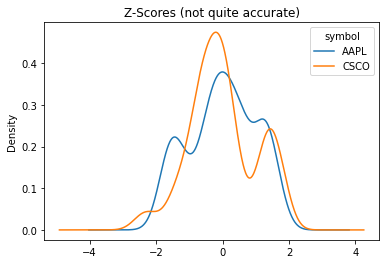

In [53]:
#.        Z-score
# a very popular transformtion in the financial time series data is z-score
# we can define a generalized lambda function to use when needed
# it allows us to mix together different symbols (high beta, low beta...) in a way that considers the statistical
# significance of any movements
#  
zscore_fxn = lambda x:(x-x.mean())/x.std()
features['f09'] = prices.groupby(level='symbol').close.apply(zscore_fxn)
features.f09.unstack().plot.kde(title='Z-Scores (not quite accurate)')

#However, the above example has a subtle but important bug. It uses the mean of the whole time frame and the standard 
#deviation of the whole time frame to calculate each datapoint. This means we are peeking ahead into the future and 
#the feature is potentially very danger-prone (it'll work famously well in sample and fail to work out of sample...).

<AxesSubplot:title={'center':'Z-Scores (improved)'}, ylabel='Density'>

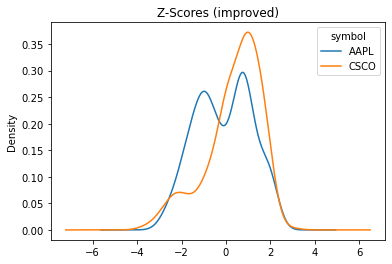

In [57]:
#to fix the issue of peeking into the future by applying the mean and std of all the time frame to each data point
zscore_improved = lambda x: (x-x.rolling(window =200, min_periods=20).mean())/x.rolling(window =200, min_periods=20).std()
features['f10'] = prices.groupby(level='symbol').close.apply(zscore_improved)
features.f10.unstack().plot.kde(title='Z-Scores (improved)')

In [61]:
#      Percentile
#the percentile transformation is useful. Using groupby and rolling can get it done
#The below example returns the percentile rank (from 0.00 to 1.00) of traded volume 
#for each value as compared to a trailing 200 day period.
rollrank_fxn = lambda x: x.rolling(window=200, min_periods=20) \
.apply(lambda x:pd.Series(x).rank(pct=True)[0])
features['f11']=prices.groupby(level='symbol').volume.apply(rollrank_fxn)


In [69]:
#Another interesting application of this same pattern is to rank each stock cross-sectionally rather than 
#longitudinally as above. 
#In other words, where does this stock rank within all of the stocks on that day, not for all prior days of that stock.
#The below example isn't very meaningful with only two stocks, but quite useful when using a realistic universe.

features['f12']=features['f07'].dropna().groupby(level='date').rank(pct=True)

In [70]:

features.head()

f01       f02         f03  f04       f05     f05_a  \
date       symbol                                                            
2015-01-02 AAPL   -0.018494       NaN         NaN  NaN       NaN       NaN   
           CSCO   -0.008973       NaN         NaN  NaN       NaN       NaN   
2015-01-05 AAPL   -0.018838 -0.009512  11080865.0  NaN  0.208269  0.208269   
           CSCO   -0.009517 -0.010503   6534091.0  NaN  0.285002  0.285002   
2015-01-06 AAPL   -0.002628  0.002729   1511625.0  NaN  0.023514  0.023514   

                   f05_b  f06  f07       f08       f09  f10  f11  f12  
date       symbol                                                      
2015-01-02 AAPL      NaN  NaN  NaN  0.000000 -0.487364  NaN  NaN  NaN  
           CSCO      NaN  NaN  NaN  0.000000 -0.682407  NaN  NaN  NaN  
2015-01-05 AAPL      0.0  NaN  NaN -0.014005 -0.783944  NaN  NaN  NaN  
           CSCO      0.0  NaN  NaN -0.009861 -0.925487  NaN  NaN  NaN  
2015-01-06 AAPL      0.0  NaN  NaN -0.009132 -0.782981  NaN  NaN  NaN

In [75]:
#.      bin
n_bins = 10
bin_fxn= lambda x: pd.qcut(x, q=n_bins,labels=range(1, n_bins+1))
features['f15'] =prices.groupby(level='symbol').volume.apply(bin_fxn)
features['f15_a'] =prices.volume.groupby(level='symbol').apply(bin_fxn)

In [81]:
#       sign
features['f16']=features['f05'].apply(np.sign)

In [86]:
#      plus-minus
#you may be interested in how many days in a row a value has increased (or decreased).
#it calculates the number of up-days minus the number of down days.
plus_minus_fnx = lambda x: x.rolling(20).sum()
features['f17']=features['f16'].groupby(level='symbol').apply(plus_minus_fnx)

In [106]:
#One-Hot Encoding is where a categorical variable is represented as a binary. 
#For instance, month_of_year would be represented as twelve different columns, each of which was either 0 or 1. 
#January would be [1,0,0,0,...0] etc...

# ordinality

month_of_the_year=prices.index.get_level_values(level='date').month

#pd.get_dummies(): Convert categorical variable into dummy/indicator variables.
one_hot_frame = pd.DataFrame(pd.get_dummies(month_of_the_year))

#Be careful! This is forcing index values without usual pandas alignments!
one_hot_frame.index = prices.index

# create column names 
begin_num = int(features.columns[-1][-2:]) + 1 #first available feature
feat_names = ['f'+str(num) for num in list(range(begin_num,begin_num+12,1))]

# rename columns and merge
one_hot_frame.columns = feat_names
features = features.join(one_hot_frame)
print(features.iloc[:,-12:].tail())


                   f18  f19  f20  f21  f22  f23  f24  f25  f26  f27  f28  f29
date       symbol                                                            
2016-12-28 CSCO      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-29 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           CSCO      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-30 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           CSCO      0    0    0    0    0    0    0    0    0    0    0    1


In [107]:
one_hot_frame

f18  f19  f20  f21  f22  f23  f24  f25  f26  f27  f28  f29
date       symbol                                                            
2015-01-02 AAPL      1    0    0    0    0    0    0    0    0    0    0    0
           CSCO      1    0    0    0    0    0    0    0    0    0    0    0
2015-01-05 AAPL      1    0    0    0    0    0    0    0    0    0    0    0
           CSCO      1    0    0    0    0    0    0    0    0    0    0    0
2015-01-06 AAPL      1    0    0    0    0    0    0    0    0    0    0    0
...                ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2016-12-28 CSCO      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-29 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           CSCO      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-30 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           CSCO      0    0    0    0    0    0    0    0    0    0    0    1

[1008 rows x 12 columns]

In [116]:
features.iloc[:,-12:]

f18  f19  f20  f21  f22  f23  f24  f25  f26  f27  f28  f29
date       symbol                                                            
2015-01-02 AAPL      1    0    0    0    0    0    0    0    0    0    0    0
           CSCO      1    0    0    0    0    0    0    0    0    0    0    0
2015-01-05 AAPL      1    0    0    0    0    0    0    0    0    0    0    0
           CSCO      1    0    0    0    0    0    0    0    0    0    0    0
2015-01-06 AAPL      1    0    0    0    0    0    0    0    0    0    0    0
...                ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2016-12-28 CSCO      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-29 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           CSCO      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-30 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           CSCO      0    0    0    0    0    0    0    0    0    0    0    1

[1008 rows x 12 columns]